# Load modules

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

import operator
from functools import reduce
from functools import partial

from timeit import default_timer
import scipy.io
import math
import gc
import glob

import h5py

from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
from scipy import stats

# Load data (will take a while) and process

In [2]:
hf_r = h5py.File(f'/oak/stanford/schools/ees/smbenson/andchu/shale_clean.hdf5', 'r')
data_x_shale = np.array(hf_r.get('x'))
data_SG_shale = np.array(hf_r.get('SG'))
data_P_shale = np.array(hf_r.get('P'))
data_P_init_shale = np.array(hf_r.get('P_init'))
hf_r.close()
print('Checkpoint 1')

Checkpoint 1


In [3]:
# GAS SATURATION DATA -------------------------------------------------
# Z SCORE NORMALIZATION
SG_mean = np.mean(data_SG_shale)
SG_std = np.std(data_SG_shale)
print(SG_mean)
print(SG_std)
    
data_SG_shale = (data_SG_shale - SG_mean)/(SG_std)

data_x = np.concatenate([data_x_shale], axis=0)
data_sg = np.concatenate([data_SG_shale], axis=0)

data_nr = data_x.shape[0]
test_nr = 500
train_nr = data_nr - test_nr

np.random.seed(0)
shuffle_index = np.random.choice(data_nr, data_nr, replace=False)

data_x = data_x[shuffle_index, ...]
data_sg = data_sg[shuffle_index, ...]

print('Checkpoint 2')

idx = [0,6,12,18,19,20,21,22,23]
data_x_fit = np.zeros((data_x.shape[0], len(idx)+3, 96, 200))
for j, index in enumerate(idx):
    data_x_fit[:,j,:,:] = data_x[:,index,:,:]
    
print('Checkpoint 3')
    
dz = 2.083330
dx = [0.1]

with open('DRV.txt') as f:
    for line in f:
        line = line.strip().split('*')
        dx.append(float(line[-1]))
dx = np.cumsum(dx)
grid_x = dx/np.max(dx)
grid_x = grid_x[1:]
grid_y = np.linspace(0, 200, 96)/np.max(dx)

data_x_fit[:,-3,:,:] = grid_x[np.newaxis, np.newaxis, :]
data_x_fit[:,-2,:,:] = grid_y[np.newaxis, :, np.newaxis]
data_x_fit[:,-1,:,:] = np.ones(data_x_fit[:,-1,:,:].shape)

data_x_fit[:,-3,:,:] = data_x_fit[:,-3,:,:]/np.max(data_x_fit[:,-3,:,:])
data_x_fit[:,-2,:,:] = data_x_fit[:,-2,:,:]/np.max(data_x_fit[:,-2,:,:])

x_in = data_x_fit.transpose((0,2,3,1))
SG = data_sg.transpose((0,2,3,1))

x_in = x_in.astype(np.float32)
SG = SG.astype(np.float32)

x_in = torch.from_numpy(x_in)
SG = torch.from_numpy(SG)

print('Checkpoint 4')

# a input u output
train_a = x_in[:train_nr,:,:,:]
train_u = SG[:train_nr,:,:,:]

test_a = x_in[train_nr:train_nr+ test_nr,:,:,:]
test_u = SG[train_nr:train_nr+ test_nr,:,:,:]

T = 24

train_a = train_a[:,:,:,np.newaxis,:]
test_a = test_a[:,:,:,np.newaxis,:]

train_a = train_a.repeat([1,1,1,T,1])
test_a = test_a.repeat([1,1,1,T,1])

print('Checkpoint 5')

t = np.cumsum(np.power(1.421245, range(24)))
t /= np.max(t)
for i in range(24):
    train_a[:,:,:,i,-1] = t[i]
    test_a[:,:,:,i,-1] = t[i]
    
train_a_SG = train_a
test_a_SG = test_a
train_u_SG = train_u
test_u_SG = test_u
    
print('Checkpoint 6')

0.019367479650039064
0.10341674964334545
Checkpoint 2
Checkpoint 3
Checkpoint 4
Checkpoint 5
Checkpoint 6


In [4]:
# PRESSURE BUILDUP ---------------------------------------------------
data_dP_shale = data_P_shale - data_P_init_shale

# Z-Score Normalization
dP_mean = np.mean(data_dP_shale)
dP_std = np.std(data_dP_shale)
print(dP_mean)
print(dP_std)

data_dP_shale = (data_dP_shale - dP_mean)/(dP_std)

data_x = np.concatenate([data_x_shale], axis=0)
data_dP = np.concatenate([data_dP_shale], axis=0)

data_nr = data_x.shape[0]
test_nr = 500
train_nr = data_nr - test_nr

np.random.seed(0)
shuffle_index = np.random.choice(data_nr, data_nr, replace=False)

data_x = data_x[shuffle_index, ...]
data_dP = data_dP[shuffle_index, ...]

print('Checkpoint 2')

idx = [0,6,12,18,19,20,21,22,23]
data_x_fit = np.zeros((data_x.shape[0], len(idx)+3, 96, 200))
for j, index in enumerate(idx):
    data_x_fit[:,j,:,:] = data_x[:,index,:,:]

print('Checkpoint 3')
    
dz = 2.083330
dx = [0.1]

with open('DRV.txt') as f:
    for line in f:
        line = line.strip().split('*')
        dx.append(float(line[-1]))
dx = np.cumsum(dx)
grid_x = dx/np.max(dx)
grid_x = grid_x[1:]
grid_y = np.linspace(0, 200, 96)/np.max(dx)

data_x_fit[:,-3,:,:] = grid_x[np.newaxis, np.newaxis, :]
data_x_fit[:,-2,:,:] = grid_y[np.newaxis, :, np.newaxis]
data_x_fit[:,-1,:,:] = np.ones(data_x_fit[:,-1,:,:].shape)

data_x_fit[:,-3,:,:] = data_x_fit[:,-3,:,:]/np.max(data_x_fit[:,-3,:,:])
data_x_fit[:,-2,:,:] = data_x_fit[:,-2,:,:]/np.max(data_x_fit[:,-2,:,:])

x_in = data_x_fit.transpose((0,2,3,1))
dP = data_dP.transpose((0,2,3,1))

x_in = x_in.astype(np.float32)
dP = dP.astype(np.float32)

x_in = torch.from_numpy(x_in)
dP = torch.from_numpy(dP)

print('Checkpoint 4')

# [3616, 96, 200, 12] = [num reservoirs, vertical length, lateral length, 12 parameters]
# [3616, 96, 200, 12] = [..., ..., ..., 24 time steps for prediction]

# a input u output
train_a = x_in[:train_nr,:,:,:]
train_u = dP[:train_nr,:,:,:]

test_a = x_in[train_nr:train_nr+ test_nr,:,:,:]
test_u = dP[train_nr:train_nr+ test_nr,:,:,:]

T = 24

train_a = train_a[:,:,:,np.newaxis,:]
test_a = test_a[:,:,:,np.newaxis,:]

train_a = train_a.repeat([1,1,1,T,1])
test_a = test_a.repeat([1,1,1,T,1])

print('Checkpoint 5')

t = np.cumsum(np.power(1.421245, range(24)))
t /= np.max(t)
for i in range(24):
    train_a[:,:,:,i,-1] = t[i]
    test_a[:,:,:,i,-1] = t[i]
    
train_a_dP = train_a
test_a_dP = test_a
train_u_dP = train_u
test_u_dP = test_u

print('Checkpoint 6')

1.1323901246254815
9.17773280445466
Checkpoint 2
Checkpoint 3
Checkpoint 4
Checkpoint 5
Checkpoint 6


# Initialize some things and helper functions

In [5]:
def R2(x,y):
    correlation_matrix = np.corrcoef(x.flatten(), y.flatten())
    correlation_xy = correlation_matrix[0,1]
    return correlation_xy**2

def MPE(true, pred):
    mask = np.logical_or(true!=0, np.abs(pred)>0.01)
    return np.mean(np.abs(pred[mask]-true[mask]))

def MRE(true, pred):
    return np.mean(np.abs(pred-true)/np.max(true, axis=(0, 1, 2))[None, None, None, :])

In [6]:
gpu_or_cpu = 'gpu'
normMethod = "zscore"

# Set torch device
device = torch.device('cuda:0')

# SG Final Model ===============================================

In [7]:
# TEST DATA
eval_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a_SG, test_u_SG), batch_size=1, shuffle=False)

from FNORUNet_5layer_model import *
model1 = torch.load('/scratch/users/andchu/FNOUNet/saved_models/SG3d_FNORUNet_199ep_32width_12m1_12m2_12m3_3000train_200eps_l2err_0.0005lr_1zerr_zscorenorm_andrew_FNORUNet4_5layer', map_location=torch.device('cuda:0'))

mpe_arr_sgtest = []
r2_arr_sgtest = []

t1 = default_timer()
with torch.no_grad():
    for x, y in eval_loader:
        x, y = x.to(device), y.to(device)
        pred = model1(x).view(-1,96,200,24)
        
        x_plot = x.cpu().detach().numpy()
        y_plot = y.cpu().detach().numpy() * SG_std + SG_mean
        pred_plot = pred.cpu().detach().numpy() * SG_std + SG_mean
     
        mpe_arr_sgtest.append(MPE(y_plot, pred_plot))
        r2_arr_sgtest.append(R2(y_plot, pred_plot))

t2 = default_timer()
print(round(t2 - t1), "seconds to predict 500 samples from the test data set for SG model")

print("Mean MPE: ", np.mean(mpe_arr_sgtest))
print("Std MPE: ", np.std(mpe_arr_sgtest))
print("Mean R^2: ", np.mean(r2_arr_sgtest))
print("Std R^2: ", np.std(r2_arr_sgtest))

41 seconds to predict 500 samples from the test data set for SG model
Mean MPE:  0.022041038
Std MPE:  0.009926171
Mean R^2:  0.9891772485021221
Std R^2:  0.011236479730175207


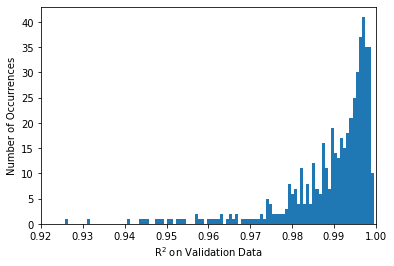

In [8]:
plt.hist(r2_arr_sgtest, bins=100)
plt.xlim([0.92, 1])
plt.xlabel('R$^2$ on Validation Data')
plt.ylabel('Number of Occurrences')
plt.show()

In [10]:
len(r2_arr_sgtest)

500

In [84]:
# TRAIN DATA
np.random.seed(0)
shuffle_index = np.random.choice(train_a_SG.size()[0], 600, replace=False)

eval_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_a_SG[shuffle_index, ...], train_u_SG[shuffle_index, ...]), batch_size=1, shuffle=False)

from FNORUNet_5layer_model import *
model1 = torch.load('/scratch/users/andchu/FNOUNet/saved_models/SG3d_FNORUNet_199ep_32width_12m1_12m2_12m3_3000train_200eps_l2err_0.0005lr_1zerr_zscorenorm_andrew_FNORUNet4_5layer', map_location=torch.device('cuda:0'))

mpe_arr_sgtrain = []
r2_arr_sgtrain = []

t1 = default_timer()
with torch.no_grad():
    for x, y in eval_loader:
        x, y = x.to(device), y.to(device)
        pred = model1(x).view(-1,96,200,24)
        
        x_plot = x.cpu().detach().numpy()
        y_plot = y.cpu().detach().numpy() * SG_std + SG_mean
        pred_plot = pred.cpu().detach().numpy() * SG_std + SG_mean
        
        mpe_arr_sgtrain.append(MPE(y_plot, pred_plot))
        r2_arr_sgtrain.append(R2(y_plot, pred_plot))
        
t2 = default_timer()
print(round(t2 - t1), "seconds to predict 500 samples from the training data set for SG model")

print("Mean MPE: ", np.mean(mpe_arr_sgtrain))
print("Std MPE: ", np.std(mpe_arr_sgtrain))
print("Mean R^2: ", np.mean(r2_arr_sgtrain))
print("Std R^2: ", np.std(r2_arr_sgtrain))

49 seconds to predict 500 samples from the training data set for SG model
Mean MPE:  0.013798997
Std MPE:  0.0047544595
Mean R^2:  0.9971252237191599
Std R^2:  0.0030146517396648182


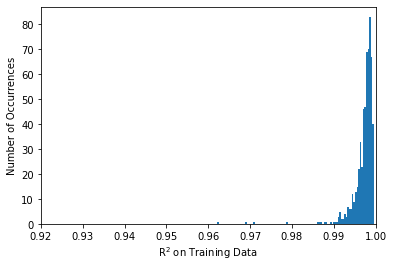

In [85]:
plt.hist(r2_arr_sgtrain, bins=100)
plt.xlim([0.92, 1])
plt.xlabel('R$^2$ on Training Data')
plt.ylabel('Number of Occurrences')
plt.show()

# dP Final Model ===============================================

In [86]:
# TEST DATA
eval_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a_dP, test_u_dP), batch_size=1, shuffle=False)

from FNORUNet_4layer_model import *
model2 = torch.load('/scratch/users/andchu/FNOUNet/saved_models/dP3d_FNORUNet_249ep_32width_12m1_12m2_12m3_3000train_250eps_l1err_0.0005lr_1zerr_zscorenorm_andrew_FNORUNet4_4layer', map_location=torch.device('cuda:0'))

mre_arr_dptest = []
r2_arr_dptest = []

t1 = default_timer()
with torch.no_grad():
    for x, y in eval_loader:
        x, y = x.to(device), y.to(device)
        pred = model2(x).view(-1,96,200,24)
        
        x_plot = x.cpu().detach().numpy()
        y_plot = y.cpu().detach().numpy() * dP_std + dP_mean
        pred_plot = pred.cpu().detach().numpy() * dP_std + dP_mean
        
        mre_arr_dptest.append(MRE(y_plot, pred_plot))
        r2_arr_dptest.append(R2(y_plot, pred_plot))
t2 = default_timer()
print(round(t2 - t1), "seconds to predict 500 samples from the test data set for dP model")

print("Mean MRE: ", np.mean(mre_arr_dptest))
print("Std MRE: ", np.std(mre_arr_dptest))
print("Mean R^2: ", np.mean(r2_arr_dptest))
print("Std R^2: ", np.std(r2_arr_dptest))

46 seconds to predict 500 samples from the test data set for dP model
Mean MRE:  0.0031870177
Std MRE:  0.0023915959
Mean R^2:  0.9966852369440425
Std R^2:  0.004486964897632156


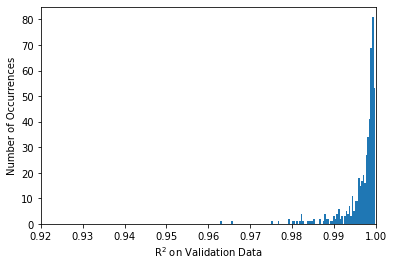

In [88]:
plt.hist(r2_arr_dptest, bins=100)
plt.xlim([0.92, 1])
plt.xlabel('R$^2$ on Validation Data')
plt.ylabel('Number of Occurrences')
plt.show()

In [87]:
#TRAIN DATA
np.random.seed(0)
shuffle_index = np.random.choice(train_a_dP.size()[0], 600, replace=False)

eval_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_a_dP[shuffle_index, ...], train_u_dP[shuffle_index, ...]), batch_size=1, shuffle=False)

from FNORUNet_4layer_model import *
model2 = torch.load('/scratch/users/andchu/FNOUNet/saved_models/dP3d_FNORUNet_249ep_32width_12m1_12m2_12m3_3000train_250eps_l1err_0.0005lr_1zerr_zscorenorm_andrew_FNORUNet4_4layer', map_location=torch.device('cuda:0'))

mre_arr_dptrain = []
r2_arr_dptrain = []

t1 = default_timer()
with torch.no_grad():
    for x, y in eval_loader:
        x, y = x.to(device), y.to(device)
        pred = model2(x).view(-1,96,200,24)
        
        x_plot = x.cpu().detach().numpy()
        y_plot = y.cpu().detach().numpy() * dP_std + dP_mean
        pred_plot = pred.cpu().detach().numpy() * dP_std + dP_mean
        
        mre_arr_dptrain.append(MRE(y_plot, pred_plot))
        r2_arr_dptrain.append(R2(y_plot, pred_plot))
t2 = default_timer()
print(round(t2 - t1), "seconds to predict 500 samples from the training data set for dP model")

print("Mean MRE: ", np.mean(mre_arr_dptrain))
print("Std MRE: ", np.std(mre_arr_dptrain))
print("Mean R^2: ", np.mean(r2_arr_dptrain))
print("Std R^2: ", np.std(r2_arr_dptrain))

51 seconds to predict 500 samples from the training data set for dP model
Mean MRE:  0.0024248927
Std MRE:  0.001655226
Mean R^2:  0.9978955066137284
Std R^2:  0.004690365527533965


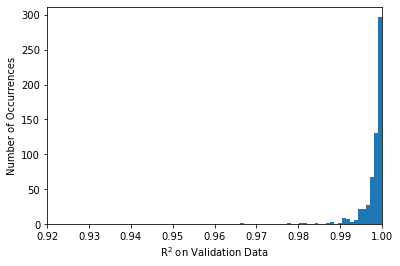

In [89]:
plt.hist(r2_arr_dptrain, bins=100)
plt.xlim([0.92, 1])
plt.xlabel('R$^2$ on Validation Data')
plt.ylabel('Number of Occurrences')
plt.show()

# Plotting all the R^2 histograms (and saving data)
# ====================================

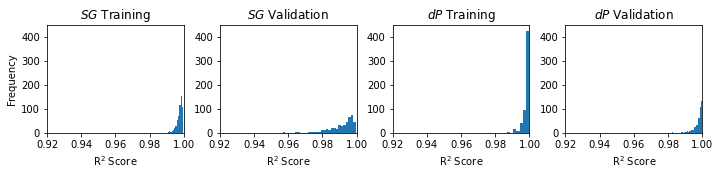

In [110]:
fig = plt.figure(figsize=(10, 5))

def plotHist(position, data, xlabel, ylabel, title):
    axsObj = fig.add_axes(position)
    
    axsObj.set_xlabel(xlabel)
    axsObj.set_ylabel(ylabel)
    axsObj.set_title(title)
    axsObj.set_xlim([0.92, 1])
    axsObj.set_ylim([0, 450])    
    axsObj.hist(data, bins=50)
    
pos = [None] * 4
pltwid = 0.19
plthei = 0.30
plty = 0.1
pos[0] = [0.05, plty, pltwid, plthei]
pos[1] = [0.29, plty, pltwid, plthei]
pos[2] = [0.53, plty, pltwid, plthei]
pos[3] = [0.77, plty, pltwid, plthei]


plotHist(pos[0], r2_arr_sgtrain, "R$^2$ Score", "Frequency", "$SG$ Training")
plotHist(pos[1], r2_arr_sgtest, "R$^2$ Score", "", "$SG$ Validation")
plotHist(pos[2], r2_arr_dptrain, "R$^2$ Score", "", "$dP$ Training")
plotHist(pos[3], r2_arr_dptest, "R$^2$ Score", "", "$dP$ Validation")

plt.show()

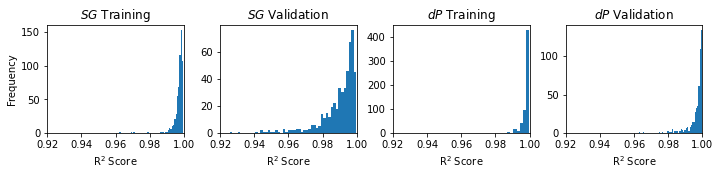

In [111]:
fig = plt.figure(figsize=(10, 5))

def plotHist(position, data, xlabel, ylabel, title):
    axsObj = fig.add_axes(position)
    
    axsObj.set_xlabel(xlabel)
    axsObj.set_ylabel(ylabel)
    axsObj.set_title(title)
    axsObj.set_xlim([0.92, 1])
#     axsObj.set_ylim([0, 450])    
    axsObj.hist(data, bins=50)
    
pos = [None] * 4
pltwid = 0.19
plthei = 0.30
plty = 0.1
pos[0] = [0.05, plty, pltwid, plthei]
pos[1] = [0.29, plty, pltwid, plthei]
pos[2] = [0.53, plty, pltwid, plthei]
pos[3] = [0.77, plty, pltwid, plthei]


plotHist(pos[0], r2_arr_sgtrain, "R$^2$ Score", "Frequency", "$SG$ Training")
plotHist(pos[1], r2_arr_sgtest, "R$^2$ Score", "", "$SG$ Validation")
plotHist(pos[2], r2_arr_dptrain, "R$^2$ Score", "", "$dP$ Training")
plotHist(pos[3], r2_arr_dptest, "R$^2$ Score", "", "$dP$ Validation")

plt.show()

In [113]:
# SAVE DATA
with open('_paper_calculateModelErr_ALL.npy', 'wb') as f:
    np.save(f, r2_arr_sgtrain)
    np.save(f, r2_arr_sgtest)
    np.save(f, r2_arr_dptrain)
    np.save(f, r2_arr_dptest)
    np.save(f, mpe_arr_sgtrain)
    np.save(f, mpe_arr_sgtest)
    np.save(f, mre_arr_dptrain)
    np.save(f, mre_arr_dptest)

# SG derivative error models ====================================

In [ ]:
# LOAD MODELS
from FNORUNet_5layer_model import *

model1 = torch.load('/scratch/users/andchu/FNOUNet/saved_models/SG3d_FNORUNet_99ep_32width_12m1_12m2_12m3_3000train_100eps_l2err_0.0005lr_0zerr_zscorenorm_andrew_FNORUNet4_5layer_0rerr', map_location=torch.device('cuda:0'))
model2 = torch.load('/scratch/users/andchu/FNOUNet/saved_models/SG3d_FNORUNet_99ep_32width_12m1_12m2_12m3_3000train_100eps_l2err_0.0005lr_0zerr_zscorenorm_andrew_FNORUNet4_5layer', map_location=torch.device('cuda:0'))
model3 = torch.load('/scratch/users/andchu/FNOUNet/saved_models/SG3d_FNORUNet_99ep_32width_12m1_12m2_12m3_3000train_100eps_l2err_0.0005lr_1zerr_zscorenorm_andrew_FNORUNet4_5layer', map_location=torch.device('cuda:0'))

In [ ]:
# TEST DATA
eval_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a_SG, test_u_SG), batch_size=1, shuffle=False)

mpe_arr_sgtest1 = []
r2_arr_sgtest1 = []
mpe_arr_sgtest2 = []
r2_arr_sgtest2 = []
mpe_arr_sgtest3 = []
r2_arr_sgtest3 = []

t1 = default_timer()
with torch.no_grad():
    for x, y in eval_loader:
        x, y = x.to(device), y.to(device)
        pred1 = model1(x).view(-1,96,200,24)
        pred2 = model2(x).view(-1,96,200,24)
        pred3 = model3(x).view(-1,96,200,24)
        
        x_plot = x.cpu().detach().numpy()
        y_plot = y.cpu().detach().numpy() * SG_std + SG_mean
        pred1_plot = pred1.cpu().detach().numpy() * SG_std + SG_mean
        pred2_plot = pred2.cpu().detach().numpy() * SG_std + SG_mean
        pred3_plot = pred3.cpu().detach().numpy() * SG_std + SG_mean
        
        mpe_arr_sgtest1.append(MPE(y_plot, pred1_plot))
        r2_arr_sgtest1.append(R2(y_plot, pred1_plot))
        mpe_arr_sgtest2.append(MPE(y_plot, pred2_plot))
        r2_arr_sgtest2.append(R2(y_plot, pred2_plot))
        mpe_arr_sgtest3.append(MPE(y_plot, pred3_plot))
        r2_arr_sgtest3.append(R2(y_plot, pred3_plot))
t2 = default_timer()
print(round(t2 - t1), "seconds to predict 500 samples from the test data set for SG derivative error models")

print("MODEL 1 ---- no derivative errors")
print("Mean MPE: ", np.mean(mpe_arr_sgtest1))
print("Std MPE: ", np.std(mpe_arr_sgtest1))
print("Mean R^2: ", np.mean(r2_arr_sgtest1))
print("Std R^2: ", np.std(r2_arr_sgtest1))

print("MODEL 2 ---- only dy/dr")
print("Mean MPE: ", np.mean(mpe_arr_sgtest2))
print("Std MPE: ", np.std(mpe_arr_sgtest2))
print("Mean R^2: ", np.mean(r2_arr_sgtest2))
print("Std R^2: ", np.std(r2_arr_sgtest2))

print("MODEL 3 ---- both dy/dr and dy/dz")
print("Mean MPE: ", np.mean(mpe_arr_sgtest3))
print("Std MPE: ", np.std(mpe_arr_sgtest3))
print("Mean R^2: ", np.mean(r2_arr_sgtest3))
print("Std R^2: ", np.std(r2_arr_sgtest3))

In [ ]:
TRAIN DATA
np.random.seed(0)
shuffle_index = np.random.choice(train_a_SG.size()[0], 600, replace=False)

eval_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_a_SG[shuffle_index, ...], train_u_SG[shuffle_index, ...]), batch_size=1, shuffle=False)

mpe_arr_sgtrain1 = []
r2_arr_sgtrain1 = []
mpe_arr_sgtrain2 = []
r2_arr_sgtrain2 = []
mpe_arr_sgtrain3 = []
r2_arr_sgtrain3 = []

t1 = default_timer()
with torch.no_grad():
    for x, y in eval_loader:
        x, y = x.to(device), y.to(device)
        pred1 = model1(x).view(-1,96,200,24)
        pred2 = model2(x).view(-1,96,200,24)
        pred3 = model3(x).view(-1,96,200,24)
        
        x_plot = x.cpu().detach().numpy()
        y_plot = y.cpu().detach().numpy() * SG_std + SG_mean
        pred1_plot = pred1.cpu().detach().numpy() * SG_std + SG_mean
        pred2_plot = pred2.cpu().detach().numpy() * SG_std + SG_mean
        pred3_plot = pred3.cpu().detach().numpy() * SG_std + SG_mean
        
        mpe_arr_sgtrain1.append(MPE(y_plot, pred1_plot))
        r2_arr_sgtrain1.append(R2(y_plot, pred1_plot))
        mpe_arr_sgtrain2.append(MPE(y_plot, pred2_plot))
        r2_arr_sgtrain2.append(R2(y_plot, pred2_plot))
        mpe_arr_sgtrain3.append(MPE(y_plot, pred3_plot))
        r2_arr_sgtrain3.append(R2(y_plot, pred3_plot))
t2 = default_timer()
print(round(t2 - t1), "seconds to predict 500 samples from the training data set for SG derivative error models")

print("MODEL 1 ---- no derivative errors")
print("Mean MPE: ", np.mean(mpe_arr_sgtrain1))
print("Std MPE: ", np.std(mpe_arr_sgtrain1))
print("Mean R^2: ", np.mean(r2_arr_sgtrain1))
print("Std R^2: ", np.std(r2_arr_sgtrain1))

print("MODEL 2 ---- only dy/dr")
print("Mean MPE: ", np.mean(mpe_arr_sgtrain2))
print("Std MPE: ", np.std(mpe_arr_sgtrain2))
print("Mean R^2: ", np.mean(r2_arr_sgtrain2))
print("Std R^2: ", np.std(r2_arr_sgtrain2))

print("MODEL 3 ---- both dy/dr and dy/dz")
print("Mean MPE: ", np.mean(mpe_arr_sgtrain3))
print("Std MPE: ", np.std(mpe_arr_sgtrain3))
print("Mean R^2: ", np.mean(r2_arr_sgtrain3))
print("Std R^2: ", np.std(r2_arr_sgtrain3))

# dP derivative error models ====================================

In [ ]:
# LOAD MODELS
from FNORUNet_4layer_model import *

model1 = torch.load('/scratch/users/andchu/FNOUNet/saved_models/dP3d_FNORUNet_99ep_32width_12m1_12m2_12m3_3000train_100eps_l1err_0.0005lr_0zerr_zscorenorm_andrew_FNORUNet4_4layer_0rerr', map_location=torch.device('cuda:0'))
model2 = torch.load('/scratch/users/andchu/FNOUNet/saved_models/dP3d_FNORUNet_99ep_32width_12m1_12m2_12m3_3000train_100eps_l1err_0.0005lr_0zerr_zscorenorm_andrew_FNORUNet4_4layer', map_location=torch.device('cuda:0'))
model3 = torch.load('/scratch/users/andchu/FNOUNet/saved_models/dP3d_FNORUNet_99ep_32width_12m1_12m2_12m3_3000train_100eps_l1err_0.0005lr_1zerr_zscorenorm_andrew_FNORUNet4_4layer', map_location=torch.device('cuda:0'))

In [ ]:
# TEST DATA
eval_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a_dP, test_u_dP), batch_size=1, shuffle=False)

mre_arr_dptest1 = []
r2_arr_dptest1 = []
mre_arr_dptest2 = []
r2_arr_dptest2 = []
mre_arr_dptest3 = []
r2_arr_dptest3 = []

t1 = default_timer()
with torch.no_grad():
    for x, y in eval_loader:
        x, y = x.to(device), y.to(device)
        pred1 = model1(x).view(-1,96,200,24)
        pred2 = model2(x).view(-1,96,200,24)
        pred3 = model3(x).view(-1,96,200,24)
        
        x_plot = x.cpu().detach().numpy()
        y_plot = y.cpu().detach().numpy() * dP_std + dP_mean
        pred1_plot = pred1.cpu().detach().numpy() * dP_std + dP_mean
        pred2_plot = pred2.cpu().detach().numpy() * dP_std + dP_mean
        pred3_plot = pred3.cpu().detach().numpy() * dP_std + dP_mean
        
        mre_arr_dptest1.append(MRE(y_plot, pred1_plot))
        r2_arr_dptest1.append(R2(y_plot, pred1_plot))
        mre_arr_dptest2.append(MRE(y_plot, pred2_plot))
        r2_arr_dptest2.append(R2(y_plot, pred2_plot))
        mre_arr_dptest3.append(MRE(y_plot, pred3_plot))
        r2_arr_dptest3.append(R2(y_plot, pred3_plot))
t2 = default_timer()
print(round(t2 - t1), "seconds to predict 500 samples from the test data set for dP derivative error models")

print("MODEL 1 ---- no derivative errors")
print("Mean MPE: ", np.mean(mre_arr_dptest1))
print("Std MPE: ", np.std(mre_arr_dptest1))
print("Mean R^2: ", np.mean(r2_arr_dptest1))
print("Std R^2: ", np.std(r2_arr_dptest1))

print("MODEL 2 ---- only dy/dr")
print("Mean MPE: ", np.mean(mre_arr_dptest2))
print("Std MPE: ", np.std(mre_arr_dptest2))
print("Mean R^2: ", np.mean(r2_arr_dptest2))
print("Std R^2: ", np.std(r2_arr_dptest2))

print("MODEL 3 ---- both dy/dr and dy/dz")
print("Mean MPE: ", np.mean(mre_arr_dptest3))
print("Std MPE: ", np.std(mre_arr_dptest3))
print("Mean R^2: ", np.mean(r2_arr_dptest3))
print("Std R^2: ", np.std(r2_arr_dptest3))

In [ ]:
# TRAIN DATA
np.random.seed(0)
shuffle_index = np.random.choice(train_a_dP.size()[0], 600, replace=False)

eval_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_a_dP[shuffle_index, ...], train_u_dP[shuffle_index, ...]), batch_size=1, shuffle=False)

mre_arr_dptrain1 = []
r2_arr_dptrain1 = []
mre_arr_dptrain2 = []
r2_arr_dptrain2 = []
mre_arr_dptrain3 = []
r2_arr_dptrain3 = []

t1 = default_timer()
with torch.no_grad():
    for x, y in eval_loader:
        x, y = x.to(device), y.to(device)
        pred1 = model1(x).view(-1,96,200,24)
        pred2 = model2(x).view(-1,96,200,24)
        pred3 = model3(x).view(-1,96,200,24)
        
        x_plot = x.cpu().detach().numpy()
        y_plot = y.cpu().detach().numpy() * dP_std + dP_mean
        pred1_plot = pred1.cpu().detach().numpy() * dP_std + dP_mean
        pred2_plot = pred2.cpu().detach().numpy() * dP_std + dP_mean
        pred3_plot = pred3.cpu().detach().numpy() * dP_std + dP_mean
        
        mre_arr_dptrain1.append(MRE(y_plot, pred1_plot))
        r2_arr_dptrain1.append(R2(y_plot, pred1_plot))
        mre_arr_dptrain2.append(MRE(y_plot, pred2_plot))
        r2_arr_dptrain2.append(R2(y_plot, pred2_plot))
        mre_arr_dptrain3.append(MRE(y_plot, pred3_plot))
        r2_arr_dptrain3.append(R2(y_plot, pred3_plot))
t2 = default_timer()
print(round(t2 - t1), "seconds to predict 500 samples from the training data set for dP derivative error models")

print("MODEL 1 ---- no derivative errors")
print("Mean MRE: ", np.mean(mre_arr_dptrain1))
print("Std MRE: ", np.std(mre_arr_dptrain1))
print("Mean R^2: ", np.mean(r2_arr_dptrain1))
print("Std R^2: ", np.std(r2_arr_dptrain1))

print("MODEL 2 ---- only dy/dr")
print("Mean MRE: ", np.mean(mre_arr_dptrain2))
print("Std MRE: ", np.std(mre_arr_dptrain2))
print("Mean R^2: ", np.mean(r2_arr_dptrain2))
print("Std R^2: ", np.std(r2_arr_dptrain2))

print("MODEL 3 ---- both dy/dr and dy/dz")
print("Mean MRE: ", np.mean(mre_arr_dptrain3))
print("Std MRE: ", np.std(mre_arr_dptrain3))
print("Mean R^2: ", np.mean(r2_arr_dptrain3))
print("Std R^2: ", np.std(r2_arr_dptrain3))